In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from PIL import Image
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import torch
import torch.nn as nn
import pickle
import os
import torch.nn.functional as F
import requests
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sn
import pandas as pd
torch.manual_seed(1) # Set manual seed
from sklearn import preprocessing
from torch.utils.data import DataLoader, Dataset, Subset

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## 1. Підготовка даних

In [ ]:
IMAGE_SIZE = 32 # Розмір зображення

# Середнє та стандартне відхилення для нормалізації даних
mean, std = [0.4914, 0.4822, 0.4465], [0.247, 0.243, 0.261]


# Налаштування перетворень для тренувального набору даних для покращення узагальнення моделі
composed_train = transforms.Compose(
    [
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)), # Зміна розміру зображення до 32x32
        transforms.RandomRotation(20), # Випадкове обертання зображення на 20 градусів
        transforms.RandomHorizontalFlip(0.1), # Випадкове горизонтальне відображення
        transforms.ColorJitter(brightness = 0.1, contrast = 0.1, saturation = 0.1),  # Налаштування яскравості, контрасту та насиченості
        transforms.RandomAdjustSharpness(sharpness_factor = 2, p = 0.1),  # Випадкове коригування різкості
        transforms.ToTensor(),  # Конвертація зображення в тензор
        transforms.Normalize(mean, std),  # Нормалізація
        transforms.RandomErasing(p=0.75,scale=(0.02, 0.1),value=1.0, inplace=False) # Випадкове видалення частини зображення
    ]
)

# Перетворення для тестового набору даних (без аугментації)
composed_test = transforms.Compose(
    [
        transforms.Resize((IMAGE_SIZE,IMAGE_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]
)

In [3]:
# Завантаження даних та застосування перетворень до них
train_dataset =  dsets.CIFAR10(root='./data', train=True, download=True, transform = composed_train)
validation_dataset = dsets.CIFAR10(root='./data', train=False, download=True, transform = composed_test)

# Створення завантажувачів даних для тренувального та валідаційного наборів з батчами по 100
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=100)
validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=100)

Files already downloaded and verified
Files already downloaded and verified


In [5]:
# Функція для відображення зображень із набору даних
def show_data(img):
    try:
        plt.imshow(img[0])
    except Exception as e:
        print(e)
    print(img[0].shape, img[0].permute(1,2,0).shape)
    plt.imshow(img[0].permute(1,2,0))
    plt.title('y = '+ str(img[1]))
    plt.show()

# Функція для конвертації тензора у формат numpy для відображення зображення з допомогою matplotlib
def im_convert(tensor):
    #Lets
    img = tensor.cpu().clone().detach().numpy() #
    img = img.transpose(1, 2, 0)
    img = img * np.array(tuple(mean)) + np.array(tuple(std))
    img = img.clip(0, 1)
    return img

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Invalid shape (3, 32, 32) for image data
torch.Size([3, 32, 32]) torch.Size([32, 32, 3])


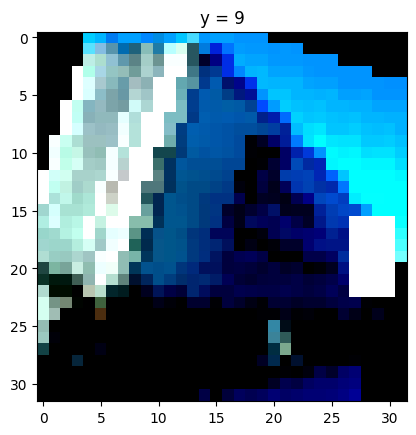

In [48]:
show_data(train_dataset[15])

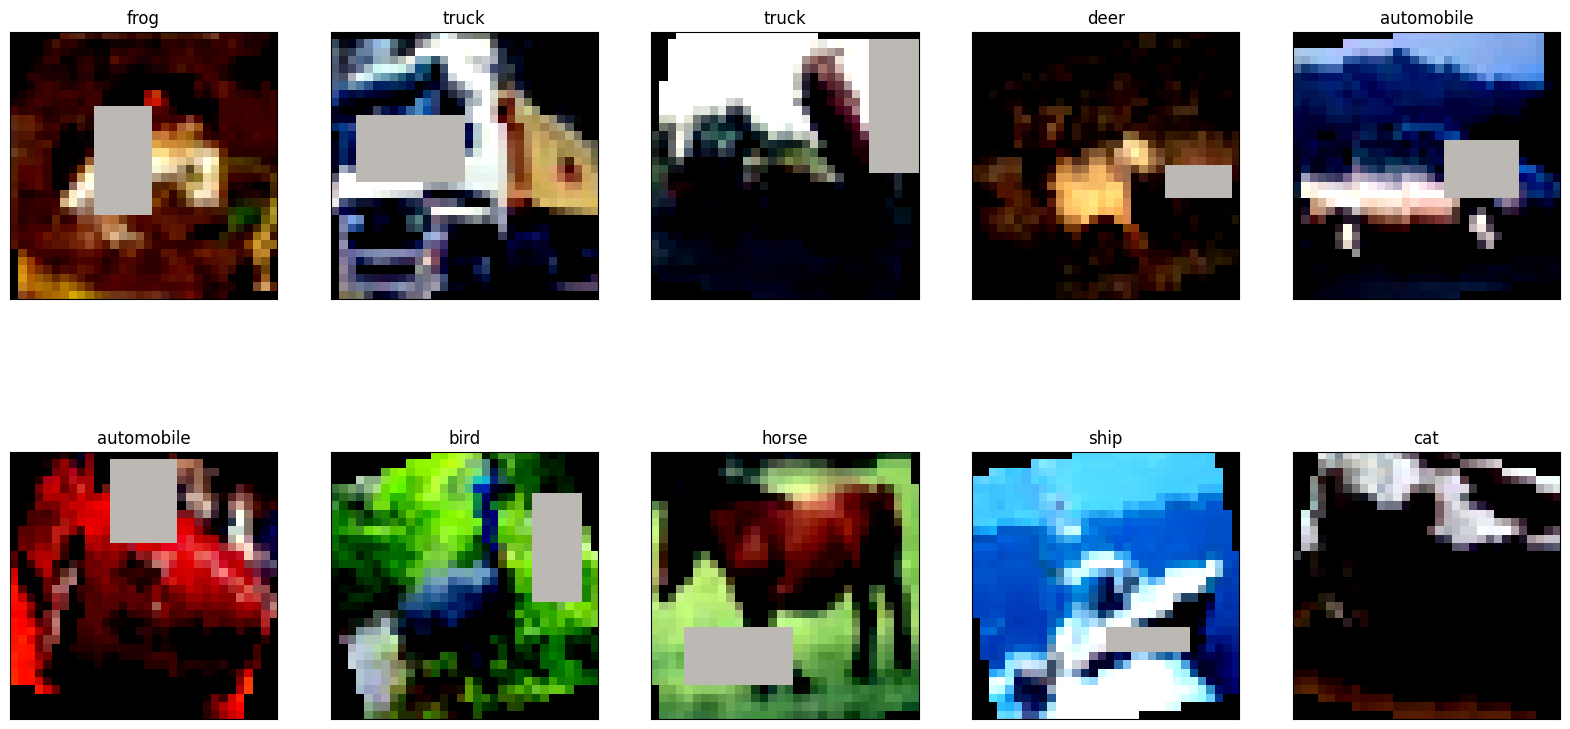

In [7]:
# Список класів (міток) CIFAR-10
classes = (
    'airplane',
    'automobile',
    'bird',
    'cat',
    'deer',
    'dog',
    'frog',
    'horse',
    'ship',
    'truck'
)

# Ітерація для завантаження першого батча зображень для відображення
data_iterable = iter(train_loader)
images, labels = next(data_iterable)
fig = plt.figure(figsize=(20, 10))

# Відображення 10 зображень із тренувального набору даних
for idx in np.arange(10):
    ax = fig.add_subplot(2, 5, idx+1, xticks=[], yticks=[])

    # Note: imshow cant print tensor !
    # Lets convert tensor image to numpy using im_convert function for imshow to print the image
    plt.imshow(im_convert(images[idx]))
    ax.set_title(classes[labels[idx].item()])

## 2. Реалізація згорткової нейронної мережі

Етапи процесу моделювання:
1) Визначити приблизну архітектуру моделі, якої слід дотримуватися (за зображення дякуємо IBM)
2) Починаємо з 2 шарів згортки та 1 повністю з'єднаного шару (fc)
3) Продовжуйте додавати приховані шари до наведеної вище моделі, і точність перевірки валідації покращиться.
4) Зверніть увагу, що збільшення кількості шарів та нейронів моделі може призвести до сповільнення навчання та збільшення ймовірності перенавчання. Також збільшення complexitu може призвести до застрягання в сідловій точці або локальних мінімумах. Тому, щоб вирішити всі ці потенційні проблеми, ми поекспериментували з ініціалізацією імпульсу, відсіву та ваги нейронів





In [12]:
def train_model(model, train_loader, validation_loader, optimizer, n_epochs = 20):

    # Global variable
    N_test = len(validation_dataset)
    accuracy_list = []
    train_loss_list = []
    model = model.to(device)
    train_cost_list = []
    val_cost_list = []

    for epoch in range(n_epochs):
        train_COST = 0
        for x,y in train_loader:
            x = x.to(device)
            y = y.to(device)
            model.train()
            optimizer.zero_grad()
            z = model(x)
            loss = criterion(z,y)
            loss.backward()
            optimizer.step()
            train_COST+=loss.item()

        train_COST = train_COST/len(train_loader)
        train_cost_list.append(train_COST)
        correct = 0

        # Perform the prediction on the validation data
        val_COST = 0
        for x_test, y_test in validation_loader:
            model.eval()
            x_test = x_test.to(device)
            y_test = y_test.to(device)
            z = model(x_test)
            val_loss = criterion(z, y_test)
            _, yhat = torch.max(z.data, 1)
            correct += (yhat==y_test).sum().item()
            val_COST+=val_loss.item()

        val_COST = val_COST/ len(validation_loader)
        val_cost_list.append(val_COST)

        accuracy = correct / N_test
        accuracy_list.append(accuracy)

        print("--> Epoch Number : {}".format(epoch + 1),
              " | Training Loss : {}".format(round(train_COST,4)),
              " | Validation Loss : {}".format(round(val_COST,4)),
              " | Validation Accuracy : {}%".format(round(accuracy * 100, 2)))

    return accuracy_list, train_cost_list, val_cost_list

In [13]:
class CNN(nn.Module):
    '''
    CNN Model V1:
    1. 2 convolution + max pool layers
    2. 1 fully connected layers
    3. Default runtime using 0 momentum and 0 dropout value
    '''

    # Constructor
    def __init__(self, out_1 = 32, out_2 = 64, number_of_classes = 10):
        super(CNN, self).__init__()
        self.cnn1 = nn.Conv2d(in_channels = 3, out_channels = out_1, kernel_size = 5, padding = 2)
        self.maxpool1 = nn.MaxPool2d(kernel_size = 2)


        self.cnn2 = nn.Conv2d(in_channels = out_1, out_channels = out_2, kernel_size = 5, padding = 2)
        self.maxpool2 = nn.MaxPool2d(kernel_size = 2)
        self.fc1 = nn.Linear(out_2 * 8 * 8, number_of_classes)
        # Calculation of how we got 8*8 is mentioned in the below comment

    # Prediction
    def forward(self, x):
        x = self.cnn1(x)
        x = torch.relu(x)
        x = self.maxpool1(x)
        x = self.cnn2(x)
        x = torch.relu(x)
        x = self.maxpool2(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        return(x)

In [15]:
# Define the model
model_mmt = CNN(out_1=32, out_2=64, number_of_classes = 10)

# Define the model learning hyperparameters
criterion = nn.CrossEntropyLoss()
learning_rate = 0.1
optimizer = torch.optim.SGD(model_mmt.parameters(), lr = learning_rate, momentum = 0.2)

# Train the model
accuracy_list_normal_mmt, train_cost_list_mmt, val_cost_list_mmt=train_model(model=model_mmt,n_epochs=20,train_loader=train_loader,validation_loader=validation_loader,optimizer=optimizer)

--> Epoch Number : 1  | Training Loss : 1.6365  | Validation Loss : 1.2654  | Validation Accuracy : 55.22%
--> Epoch Number : 2  | Training Loss : 1.3117  | Validation Loss : 1.0824  | Validation Accuracy : 62.07%
--> Epoch Number : 3  | Training Loss : 1.2012  | Validation Loss : 1.0022  | Validation Accuracy : 65.34%
--> Epoch Number : 4  | Training Loss : 1.1326  | Validation Loss : 0.9639  | Validation Accuracy : 66.71%
--> Epoch Number : 5  | Training Loss : 1.0864  | Validation Loss : 0.9217  | Validation Accuracy : 68.38%
--> Epoch Number : 6  | Training Loss : 1.0453  | Validation Loss : 0.9291  | Validation Accuracy : 69.12%
--> Epoch Number : 7  | Training Loss : 1.0239  | Validation Loss : 0.8957  | Validation Accuracy : 69.78%
--> Epoch Number : 8  | Training Loss : 0.9971  | Validation Loss : 0.8803  | Validation Accuracy : 70.61%
--> Epoch Number : 9  | Training Loss : 0.9836  | Validation Loss : 0.887  | Validation Accuracy : 69.73%
--> Epoch Number : 10  | Training Loss

In [16]:
# Save model:
model_mmt = pickle.load(open('./model/CNN_momentum_V1.pkl', 'rb'))

## Додано ще один прихований шар у сегмент Повністю зв'язаної моделі. Використано імпульс = 0.2 та значення відсіву = 0.5

In [17]:
class CNN_V2(nn.Module):
    '''
    CNN Model V2:
    1. 2 convolution & max pool layers
    2. 2 fully connected layers
    3. Default runtime using 0.2 momentum and dropout value p = 0.5
    '''
    # Constructor
    def __init__(self, out_1 = 32, out_2 = 64, number_of_classes = 10, p = 0):
        super(CNN_V2, self).__init__()
        self.cnn1 = nn.Conv2d(in_channels = 3, out_channels = out_1, kernel_size = 5, padding = 2)
        self.maxpool1 = nn.MaxPool2d(kernel_size = 2)


        self.cnn2 = nn.Conv2d(in_channels = out_1, out_channels = out_2, kernel_size = 5, padding = 2)
        self.maxpool2 = nn.MaxPool2d(kernel_size = 2)
        self.fc1 = nn.Linear(out_2 * 8 * 8, 1000) # Roughly taken seein the input and the output
        self.drop = nn.Dropout(p=p)
        self.fc2 = nn.Linear(1000, number_of_classes)

    # Prediction
    def forward(self, x):
        x = self.cnn1(x)
        x = torch.relu(x)
        x = self.maxpool1(x)
        x = self.cnn2(x)
        x = torch.relu(x)
        x = self.maxpool2(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = F.relu(self.drop(x))
        x = self.fc2(x)
        return(x)

In [25]:
# Define the model
model_mmtv2 = CNN_V2(out_1=64, out_2=128, number_of_classes = 10, p=0.5)

# Define model learning hyperparamters
criterion = nn.CrossEntropyLoss()
learning_rate = 0.1
optimizer = torch.optim.SGD(model_mmtv2.parameters(), lr = learning_rate, momentum = 0.2)

# Train the model
accuracy_list_normal, train_cost_list, val_cost_list=train_model(
    model=model_mmtv2,
    n_epochs=25,
    train_loader=train_loader,
    validation_loader=validation_loader,
    optimizer=optimizer
)

--> Epoch Number : 1  | Training Loss : 1.6694  | Validation Loss : 1.3235  | Validation Accuracy : 53.44%
--> Epoch Number : 2  | Training Loss : 1.3266  | Validation Loss : 1.0652  | Validation Accuracy : 61.9%
--> Epoch Number : 3  | Training Loss : 1.1638  | Validation Loss : 0.9614  | Validation Accuracy : 66.13%
--> Epoch Number : 4  | Training Loss : 1.0605  | Validation Loss : 0.9144  | Validation Accuracy : 68.17%
--> Epoch Number : 5  | Training Loss : 0.9846  | Validation Loss : 0.8437  | Validation Accuracy : 70.42%
--> Epoch Number : 6  | Training Loss : 0.9256  | Validation Loss : 0.7755  | Validation Accuracy : 73.33%
--> Epoch Number : 7  | Training Loss : 0.8624  | Validation Loss : 0.7564  | Validation Accuracy : 73.74%
--> Epoch Number : 8  | Training Loss : 0.8237  | Validation Loss : 0.7623  | Validation Accuracy : 74.25%
--> Epoch Number : 9  | Training Loss : 0.7874  | Validation Loss : 0.7056  | Validation Accuracy : 76.09%
--> Epoch Number : 10  | Training Loss

In [26]:
# Save model
model_mmtv2 = model_mmtv2.to(torch.device("cpu"))
pickle.dump(model_mmtv2, open('./model/CNN_momentum_V2.pkl', 'wb'))

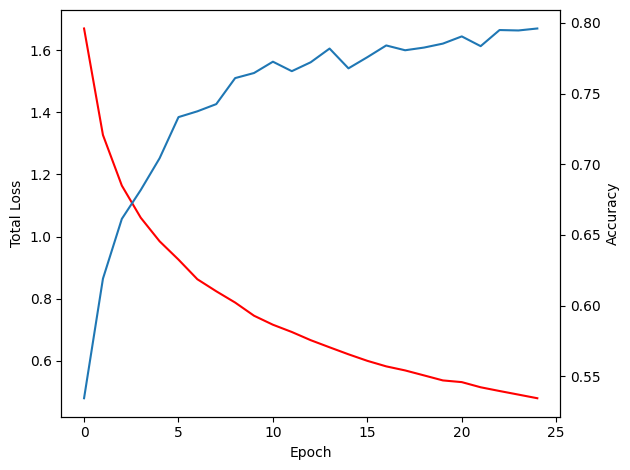

In [35]:
# Графік навчальної втрати та точності
fig, ax1 = plt.subplots()
ax1.plot(train_cost_list, color="red")
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Total Loss')
ax1.tick_params(axis='y')

# Другий графік точності, накладений на перший
ax2 = ax1.twinx()
ax2.set_ylabel('Accuracy')
ax2.plot(accuracy_list_normal)
ax2.tick_params(axis='y')
fig.tight_layout()
plt.show()

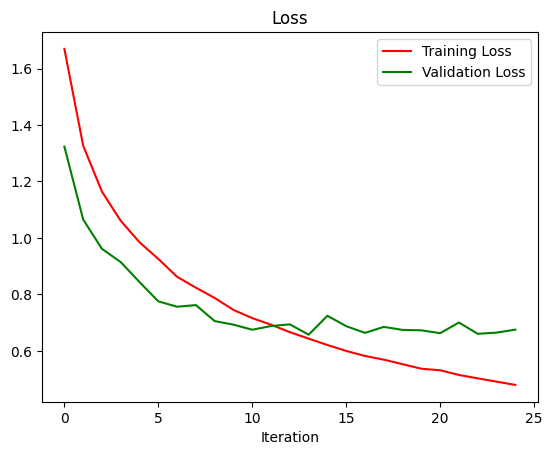

In [ ]:
plt.plot(train_cost_list, 'r', label='Training Loss')
plt.plot(val_cost_list,  'g', label='Validation Loss')
plt.xlabel("Iteration")
plt.title("Loss")
plt.legend()
plt.show()

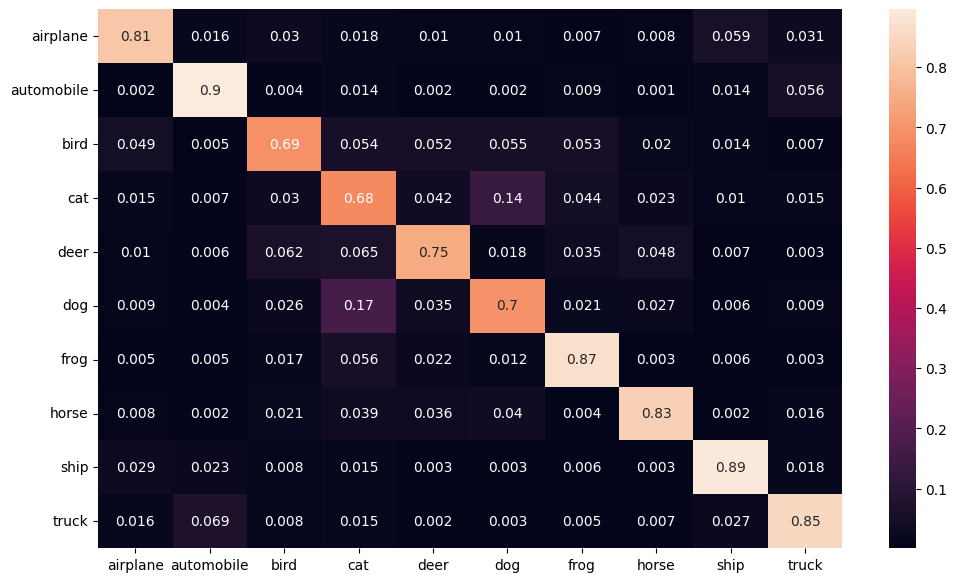

In [ ]:
y_pred = []
y_true = []

# Ітерація над тестовими даними для отримання прогнозів
for x, y in torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=1):
    x, y = x.to(device), y.to(device)
    z = model_mmtv2(x)
    _, yhat = torch.max(z, 1)
    y_pred.extend(yhat.cpu().numpy())
    y_true.extend(y.cpu().numpy())

# Побудова матриці неточностей
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix) * 10, index=classes, columns=classes)
plt.figure(figsize=(12,7))
sn.heatmap(df_cm, annot=True)
plt.savefig('output.png')
plt.show()

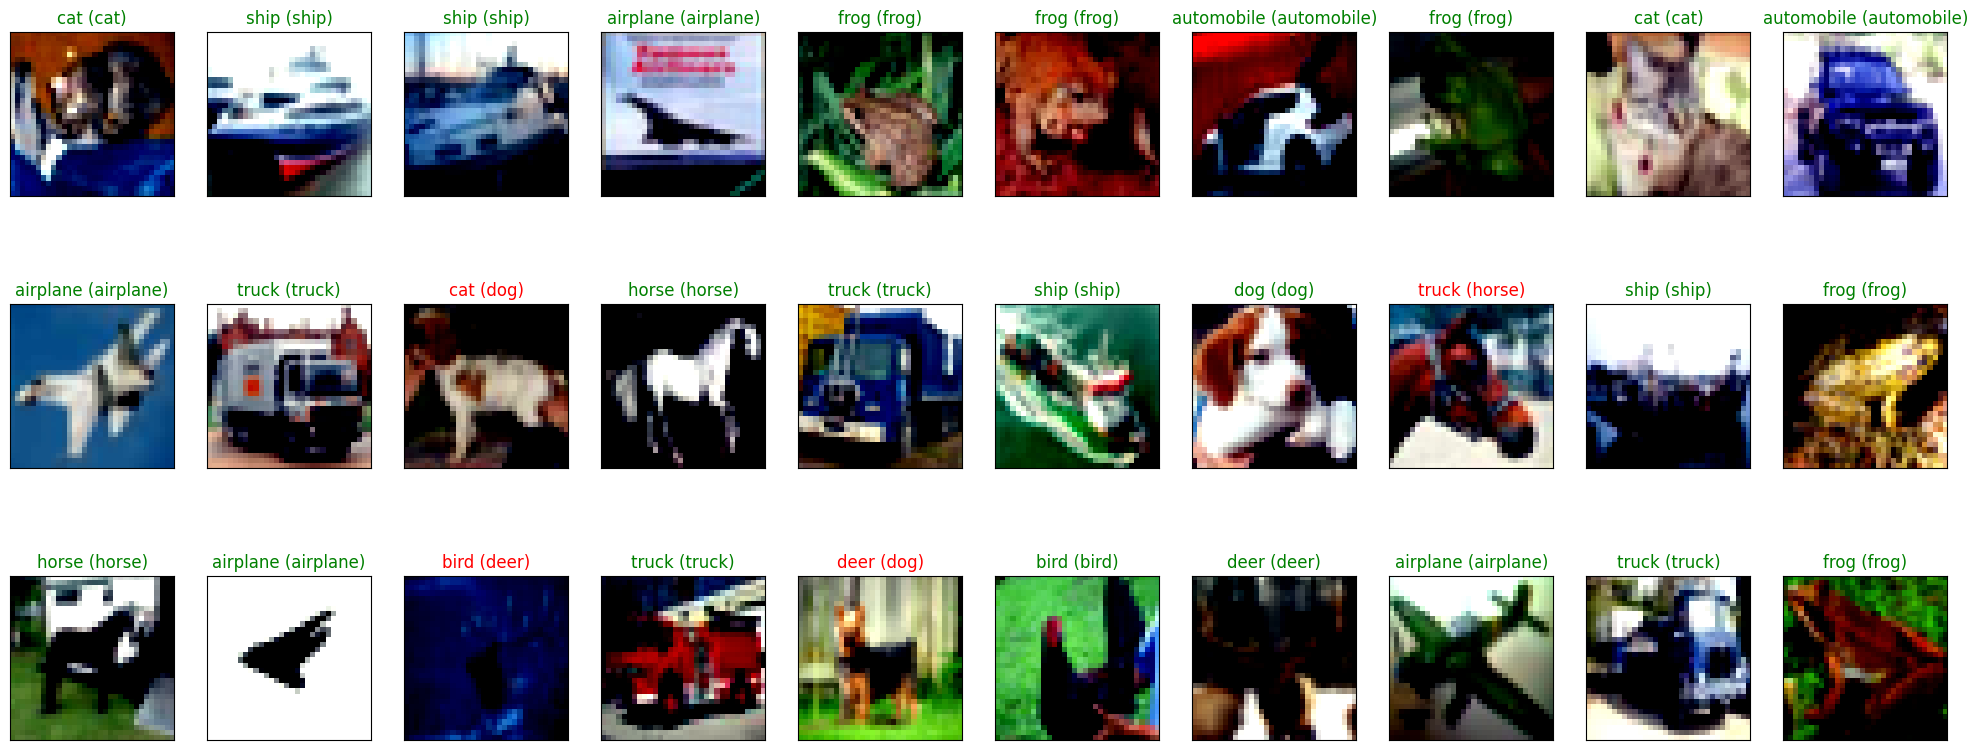

In [55]:
data_iterable = iter(validation_loader)
images, labels = next(data_iterable)
images, labels = images.to(device), labels.to(device)
output = model_mmtv2(images)
_, preds = torch.max(output, 1)

fig = plt.figure(figsize=(25, 10))  # Збільшимо висоту фігури для 30 зображень
for idx in np.arange(30):  # Відобразимо 30 зображень
    ax = fig.add_subplot(3, 10, idx+1, xticks=[], yticks=[])
    plt.imshow(im_convert(images[idx]))
    ax.set_title(f"{classes[preds[idx]]} ({classes[labels[idx]]})",
                 color=("green" if preds[idx] == labels[idx] else "red"))
plt.show()


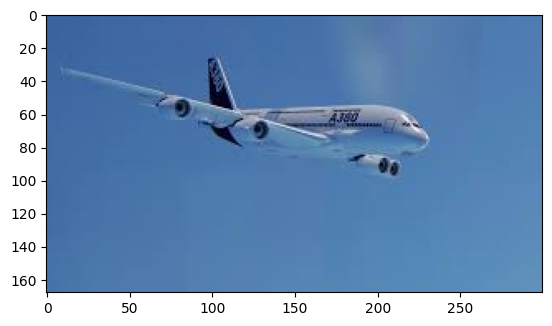

Prediction by Model: airplane


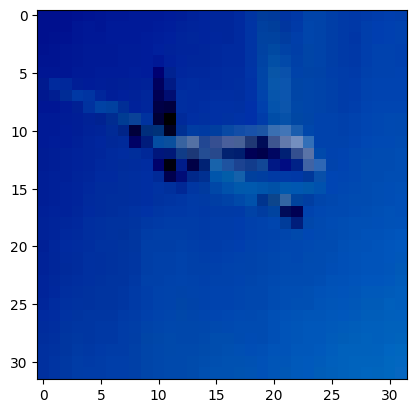

In [31]:
from PIL import Image
import requests

# Приклад зображення з Інтернету
url = 'https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcRsa3ISspmdRq4nDC9M6pfoNh1TvukFHBzGuA&usqp=CAU'
response = requests.get(url, stream=True)
img = Image.open(response.raw)
plt.imshow(img)
plt.show()

# Перетворення для моделі
img = composed_test(img)
plt.imshow(im_convert(img))
img = img.to(device).unsqueeze(0)
output = model_mmtv2(img)
_, pred = torch.max(output, 1)
print("Prediction by Model:", classes[pred.item()])
